# Spatial referencing systems and metadata

In this class we are going to cover:
- Spatial referencing systems (a quick overview)
- Satellite image metadata (and some more indepth examples, often relating to the crs).


## Working with a Coordinate Reference System (CRS)

We need to be able to map data points to precise locations across space. Indeed, this underpins our ability to process and analyze satellite images. 

There are hundreds of different types of Coordinate Reference Systems, with many geographic regions specifying their own to enable local consistency and precision. 

- A **Geographic Coordinate System** measures locations on Earth in latitude and longitude and is based on either a spherical or ellipsoidal coordinate system. 
    - Latitude is measured in degrees north or south of the equator. 
    - Longitude is measured in degrees east or west of a prime meridian (a meridian divides a spheroid into two hemispheres).
    - See the World Geodetic System (WGS84/EPSG:4326):https://en.wikipedia.org/wiki/World_Geodetic_System


- A **Projected Coordinate System** instead represents Earth locations via a specific map projection using cartesian coordinates (x,y) on a planar (2D) surface. 
    - This approach maps a curved Earth surface onto a flat 2D plane. 
    - Common units include metric meters and imperial feet. 
    - See the Universal Transverse Mercator (UTM): https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system
    - Or the WGS 84 Pseudo-Mercator: https://epsg.io/3857
    

## Satellite imagery metadata

We often have information about our data which is not actually the data itself. 

This is referred to as **Metadata**. 

('Meta' meaning 'above' or 'beyond')

We will need to import `rasterio` so that we can load the Planet image data we downloaded in the previous tutorial.

In [1]:
# Example
# Load rasterio into our jupyter session
import rasterio

Let's get started using a 4-band Planet image.

We will need to specify the image name, and then use the `rasterio` open function to load the raster.

The desired image filename is '20190321_174348_0f1a_3B_AnalyticMS.tif', which you can download from here: 

https://hello.planet.com/data/s/UG2TX98suVmmi9q/download

In [2]:
# Example
image_filename = "20160831_180303_0e26_3B_AnalyticMS.tif"

# Remember that the 4-band image is comprised of blue, green, red and near-infrared
# PlanetScope images should be in a UTM projection.
my_image = rasterio.open(image_filename)
my_image

<open DatasetReader name='20160831_180303_0e26_3B_AnalyticMS.tif' mode='r'>

We can now begin to explore information about the loaded Planet image asset.

For example, we can view the filename for the given image asset using the `.name()` function:

In [3]:
# Example
print(my_image.name)

20160831_180303_0e26_3B_AnalyticMS.tif


We can also view the image tags associated with the image asset via the `.tags()` function, which include:
- 'AREA_OR_POINT' - defines the type of image asset (area or point).
- 'TIFFTAG_DATETIME' - the specific date and time the image was taken in Coordinated Universal Time (UTC).

In [4]:
# Example
print(my_image.tags())

{'AREA_OR_POINT': 'Area', 'TIFFTAG_DATETIME': '2016:08:31 18:03:03'}


In case we need to check, we can obtain the number of bands which are present within this image.

Can you remember what these four bands will be?

In [5]:
# Example
# Present number of image bands
print(my_image.count)

4


We can also check the number of indexes available.

Following the Geospatial Data Abstraction Library (GDAL) convention, these are indexed starting with the number 1, and therefore are not zero-indexed like python.

In [6]:
# Example
# Present number of indexes
print(my_image.indexes)

(1, 2, 3, 4)


By querying the image object with these basic functions, we can establish information prior to visualizing. 

Finally, we can unpack these different layers as follows (remember we practiced unpacking in previous classes):

In [7]:
# Example
# Unpacking our image layers into separate variables for blue, green, red and infrared:
blue, green, red, nir = my_image.read()

# Let's inspect our blue variable
blue

# If you see lots of zeros, inspect this image in a GIS and think about why this is!
# Hint: What is the orientation?

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

Remember that these are `numpy` arrays:

e.g. `array([0, 0, ..., 0, 0])`

There are actually many ways we can unpack these bands, they might just take a few more lines of code. 

For example:


In [8]:
# Example
blue = my_image.read(1)
green = my_image.read(2)
red = my_image.read(3)
nir = my_image.read(4)

blue

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

Or it is possible to just read all the layers at once, creating a large multidimensional array:

In [9]:
# Example
data = my_image.read()
data

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)

Remember, this multidimensional array is essentially a list of lists, we can still index into the array like we have previously in the Python tutorial example (should we need to):

In [10]:
# Example
# Extract the blue array which will be in position zero
blue = data[0]
blue

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

If you are still unsure about layer order, check the documentation:

- https://developers.planet.com/docs/data/psscene/
        

Finally, we can examine the dimensions of one of these layers:

In [11]:
# Example
# Print the data type of the blue layer (which will be a NumPy data type) 
print(blue.dtype)
print(blue.shape)

# Using the blue band as an example, examine the width & height of the image (in pixels)
w = blue.shape[0]
h = blue.shape[1]

# Let's print the dimensions of the blue layer 
print("width: {w}, height: {h}".format(w=w, h=h))


uint16
(4658, 9357)
width: 4658, height: 9357


Let's double check those width and heights aginst the raster axis in the underlying image, as explored in the previous class:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


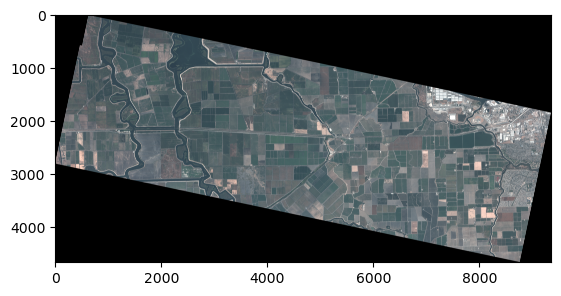

In [12]:
# Example
import numpy as np
from matplotlib import pyplot

def scale(band): # scale values for display purposes
    return band / 10000.0

my_raster_image = rasterio.open("20160831_180303_0e26_3B_AnalyticMS.tif")

blue = scale(my_raster_image.read(1))
green = scale(my_raster_image.read(2))
red = scale(my_raster_image.read(3))

rgb = np.dstack((red, green, blue))
pyplot.imshow(rgb)

## Exercise

With the image on the GitHub repo called `clipped.tif`, follow these processing steps:

- Load the image.
- Check the layer count and images. Print them to the console. Write a note interpreting them. 
- Visualize your image as a true color composite. 



In [13]:
# Enter your attempt below:


### Measuring the spatial distance of your image

Remember, widths/heights of the image are the underlying metrics for the raster image. They are not a set of spatial reference coordinates. 

Therefore, we can get the bounds of the current image in the current projected coordinate reference system using the `.bounds` command.

Remember, PlanetScope data should be in UTM, the Universal Transverse Mercator system: https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system

The measurement unit should be meters (as opposed to degrees when using lat-lon coordinates via WGS84).

First, you want to check this is correct using the `.crs()` function:

In [14]:
# Example
my_image.crs

CRS.from_epsg(32610)

You can actually view all of the metadata if you call the `.profile` function.

Some of the key parts here include the `.transform` function, which we will get to later.

In [15]:
# Example
my_image.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 9357, 'height': 4658, 'count': 4, 'crs': CRS.from_epsg(32610), 'transform': Affine(3.0, 0.0, 622023.0,
       0.0, -3.0, 4206579.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}

Now you can begin to explore the geographic bounds of the image in the underlying crs, using the `.bounds` function. 

In [16]:
# Example
# Find the bounding box of the image.
# The bounding box is the minimum possible box which envelopes the present data.
print(my_image.bounds)

BoundingBox(left=622023.0, bottom=4192605.0, right=650094.0, top=4206579.0)


We can then get the image unit dimensions, in the original units of the coordinate reference system, by subtracting the different bounds of the image.

Firstly, let's look at the function available to us to get the corner coordinate bounds of our image:

In [17]:
# Example
# It is possible to call each bound like so:
my_image.bounds.left

622023.0

In [18]:
# Example
# It is possible to call each bound like so:
my_image.bounds.right

650094.0

Therefore, we can now put this together to get the image width and height.

In [19]:
# Example
# Find the image bound in the original measurement units
width_in_projected_units = my_image.bounds.right - my_image.bounds.left
height_in_projected_units = my_image.bounds.top - my_image.bounds.bottom

print("Width: {} meters, Height: {} meters".format(
    round(width_in_projected_units), 
    round(height_in_projected_units)
))

Width: 28071 meters, Height: 13974 meters


## Exercise

Open this image in a GIS and verify that the width and height of the image bounds match up!

In QGIS, you can use the measure line feature. 

Finally, describe why this process is important in the box below:

In [20]:
# Enter your attempt here


### Finding the number of raster grid tiles

Remember that this raster image will be comprised of a grid.

We can therefore find the total number of rows and columns by using the height and width commands, as follows:

In [21]:
# Find the height and width of our image using the relevant functions:
print("Rows: {}, Columns: {}".format(my_image.height, my_image.width))

Rows: 4658, Columns: 9357


## Exercise

For your `clipped.tif` image, find the number of raster grid tiles present.

In [22]:
# Enter your attempt below


### Finding the resolution of a single pixel

We may want to clarify the dimensions of a single pixel in our raster grid.

Thus, we can find the resolution of the x and y pixels as follows: 

In [23]:
# Find the resolution of a single pixel
x_length = (my_image.bounds.right - my_image.bounds.left) / my_image.width
y_length = (my_image.bounds.top - my_image.bounds.bottom) / my_image.height

print("Length of x is: {}. Length of y is: {}".format(x_length, y_length))
print("Therefore, it is {} that the pixels are square, with dimensions {} x {} meters.".format(
    x_length == y_length, x_length, y_length))

Length of x is: 3.0. Length of y is: 3.0
Therefore, it is True that the pixels are square, with dimensions 3.0 x 3.0 meters.


## Exercise

Using your `clipped.tif` image, explore what the resolution of each pixel is.

Reflect on the answer. Compare your finding to other image sources. 

In [24]:
# Enter your attempt below


### Changing raster pixel coordinates to geographic coordinates

It is important for us to be able to change the pixel coordinates, which we can do via an affine transformation.

See here for more info: https://en.wikipedia.org/wiki/Affine_transformation
   
Think of an affine transformation as a geometry transformation. So for any set of raster pixel coordinates, we can convert these values into geographic coordinates. 

Therefore, to get geographic coordinates for the image bounds we've been working with, we must:

- Get the min and max pixel index coordinate values of the image.
- Then multiply the `.transform` function by these values to get geographic equivalents. 

The minimum and maximum values for the x and y axes of an image are highly useful as we can use them to construct a bounding box. Bounding boxes are useful as they can help speed up spatial processing, for example, when carrying out intersections between different objects. 

Let's cover a basic example:    


In [29]:
# Example
# To convert from pixel coordinates to spatial coordinates, we need the min and max index values.

# Upper left pixel coordinates
row_min = 0
col_min = 0

# Lower right pixel coordinates.  
# Remember our index here starts at zero, hence we need to subtract 1.
row_max = my_image.width - 1
col_max = my_image.height - 1

print(
    'The top left coordinate is {}.'.format((row_min,col_min)),
    'The lower right coordinate is {}.'.format((row_max,  col_max)),
)
print(my_image.crs)

The top left coordinate is (0, 0). The lower right coordinate is (9356, 4657).
EPSG:32610


Now we can transform these coordinates using the available `.transform` function.

This converts our given row coordinates into our present CRS coordinates.

In [30]:
# Transform coordinates with the dataset's affine transformation.
topleft = my_image.transform * (row_min, col_min)
botright = my_image.transform * (row_max, col_max)

print("Top left corner coordinates: {}".format(topleft))
print("Bottom right corner coordinates: {}".format(botright))

Top left corner coordinates: (622023.0, 4206579.0)
Bottom right corner coordinates: (650091.0, 4192608.0)


The `.transform` function requires a tuple of raster index coordinates, and returns the geographic coordinates corresponding to this tuple.

## Exercise

You are given a set of locations across San Francisco as raster index coordinates. Convert them to geographic coordinates and identify the location using a qgis:

- 3680, 1500
- 5100, 3000
- 5100, 2500
- 6950, 2300

In [27]:
# Enter your attempt here
